# Try artificial neural netwroks on the bulk RNA-seq data (simulation study)

## Load the required libraries

In [1]:
set.seed(0)
library(keras)
library(ggplot2)
library(pheatmap)

## Load the partitioned and normalized data (to save I/O operations)

In [2]:
load("../Stem_Net_MinMaxNormalized_data.RData")

### List of variables in the workspace after loading the data file

In [3]:
print(ls())

[1] "test_x"  "test_y"  "train_x" "train_y" "x"       "y"      


Here we ignore the y, test_y, and train_Y variables as they represent the single cell expression data stored in the RData file. We should instead replace these values with the corresponding bulk expression data.

### Dimensions of the training and test data

In [4]:
print("train:")
print(dim(train_x))

print("test:")
print(dim(test_x))

[1] "train:"
[1] 11396   726
[1] "test:"
[1] 2850  726


In [5]:
print(range(train_x))
print(range(train_y))

print(range(test_x))
print(range(test_y))

[1] 0 1
[1] 0 1
[1]  0.00000 19.46097
[1] 0.000000 1.430561


## Read the bulk expression data

In [6]:
bulk.rna <- read.table("/MMCI/MS/ExpRegulation/work/data/singleCell/iPCs_Kathrin/bulkRNAseq_TPM.txt")

## Subset the bulk RNA data according to the genes split into training and test set

In [7]:
## Find the corresponding indices
training.hits <- which(rownames(bulk.rna) %in% rownames(train_x))
test.hits <- which(rownames(bulk.rna) %in% rownames(test_x))

print(length(training.hits))
print(length(test.hits))

[1] 11396
[1] 2850


In [8]:
## Perform subsetting
train_y <- bulk.rna[training.hits, 2] # 2 for selecting CEL_R2_HLC
test_y <- bulk.rna[test.hits, 2] # 2 for selecting CEL_R2_HLC

## Generate the simulated values for response

In [9]:
y.sim.train <- 10 * rowMeans(train_x)^2 + rnorm(n= nrow(train_x), mean= 0, sd= .001)
y.sim.test <- 10 * rowMeans(test_x)^2 + rnorm(n= nrow(test_x), mean= 0, sd= .001)

## Normalize the response

In [10]:
# Normalize the response
mins <- min(y.sim.train)
maxs <- max(y.sim.train)
print(mins)
print(maxs)
y.sim.train <- (y.sim.train - mins) / (maxs - mins)
y.sim.test <- (y.sim.test - mins) / (maxs - mins)

print(range(y.sim.train))
print(range(y.sim.test))

[1] -0.003055478
[1] 0.2273874
[1] 0 1
[1] 0.002336515 0.351966706


## Correlation between Feature and response #1
To briefly test how well the features are correlated with the simulated response on training and test data test

In [11]:
cor.res <- sapply(seq(ncol(train_x)), function(i) cor(train_x[, i], y.sim.train))

print("correlation on training")
print(range(cor.res))

[1] "correlation on training"
[1] -0.0152719  0.7094157


In [12]:
cor.res <- sapply(seq(ncol(test_x)), function(i) cor(test_x[, i], y.sim.test))
                  
print("correlation on test")
print(range(cor.res))

[1] "correlation on test"
[1] -0.02791271  0.68387521


## Set the NN hyper-parameters

In [13]:
epochs <- 200
early_stop_patience <- 20
hidden_layer <- 50 #c(floor(mean(ncol(train_x), ncol(train_y))))
#hidden_layer <- c(512, 256, 128)
print("hiddenlayer info:")
print(hidden_layer)
activation_func <- c("tanh")#, "tanh", "tanh")
drop_out_rate <- .01
batch_size <- 16
val_split_ratio <- .1
l1_lambda <- l2_lambda <- .0

[1] "hiddenlayer info:"
[1] 50


## Build the NN model

In [14]:
model <- keras_model_sequential()

# build the 1st layer
layer_dense(model, units= hidden_layer[1], activation= activation_func[1], input_shape= ncol(train_x),
            kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
model <- layer_dropout(model, rate= drop_out_rate)

# add the other hidden layers
if(length(hidden_layer) > 1){
    for(i in seq(2, length(hidden_layer))){
        model <- layer_dense(model, units= hidden_layer[i], activation= activation_func[i],
                          kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
        model <- layer_dropout(model, rate= drop_out_rate)
    }
}

# finish off by adding the output layer
model <- layer_dense(model, units= 1, activation = "tanh")

## Compile the model

In [15]:
compile(model, loss= "mse", optimizer= optimizer_rmsprop(), metrics= list("mean_absolute_error"))

## Summary of the model

In [16]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 50)                      36350       
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 50)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       51          
Total params: 36,401
Trainable params: 36,401
Non-trainable params: 0
________________________________________________________________________________


## Fit the data to the built and compiled model
Since there are various replicates for the bulk RNA-seq data, we train a separate NN model for each.

In [17]:
early_stop <- callback_early_stopping(monitor= "val_loss", patience= early_stop_patience)

history <- fit(model, as.matrix(train_x), y.sim.train, 
               epochs= epochs, batch_size= batch_size, validation_split= val_split_ratio,
               verbose= 1, callback= list(early_stop))


## Model performance per epoch

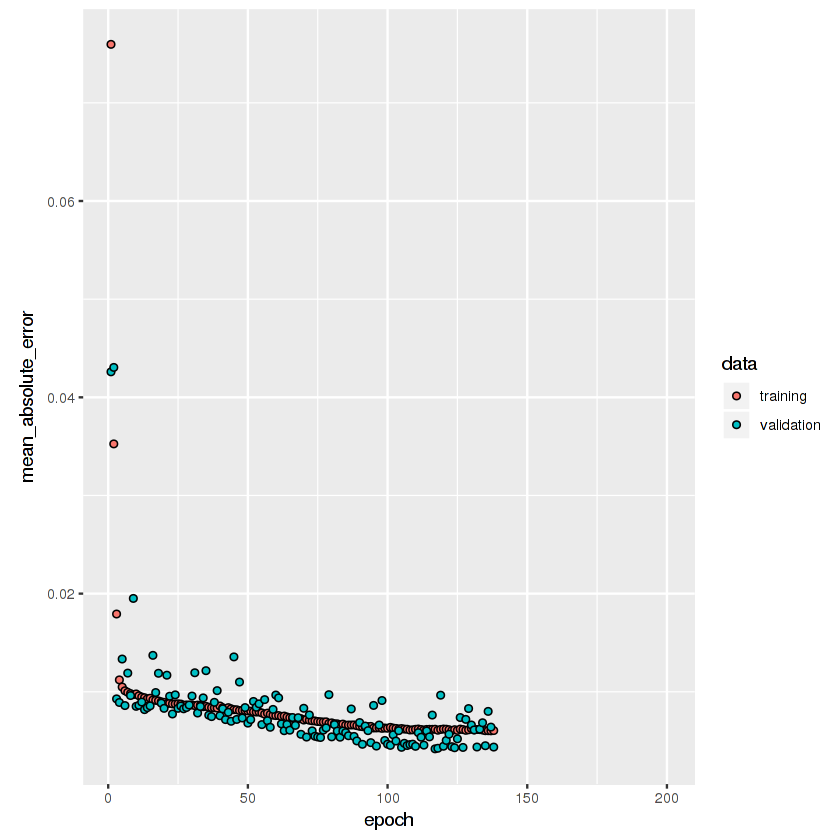

In [18]:
print(plot(history, metrics = "mean_absolute_error", smooth = FALSE))

## Predict the response

In [19]:
pred.train <- predict(model, as.matrix(train_x))
pred.test <- predict(model, as.matrix(test_x))

## Plot the response (perdicted and measured) on the training data

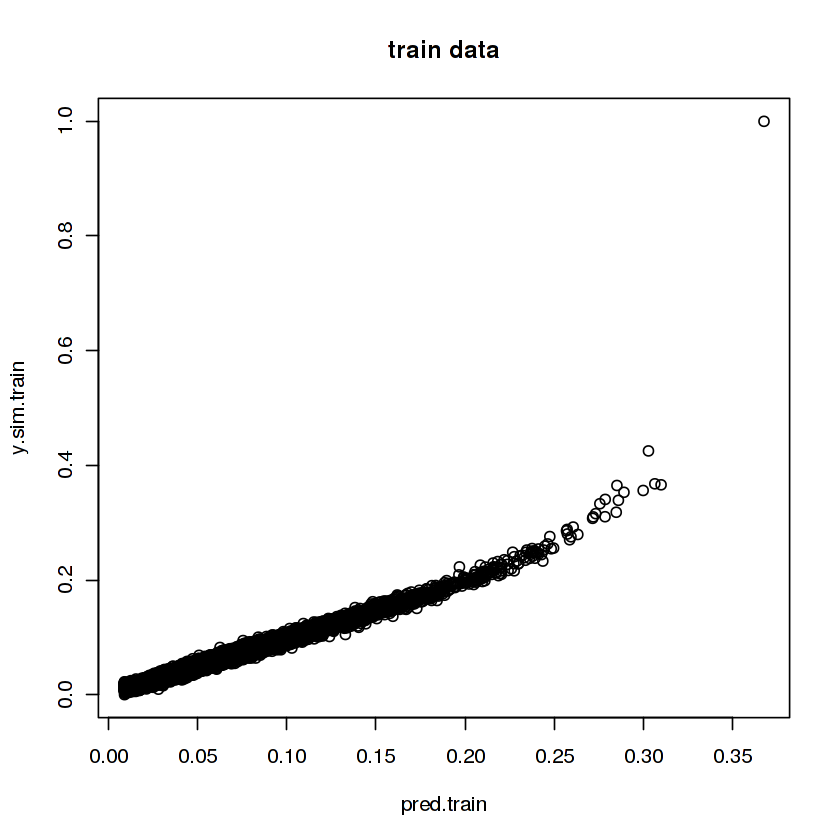

In [20]:
plot(pred.train, y.sim.train, main= "train data")

## Plot the response (perdicted and measured) on the test data

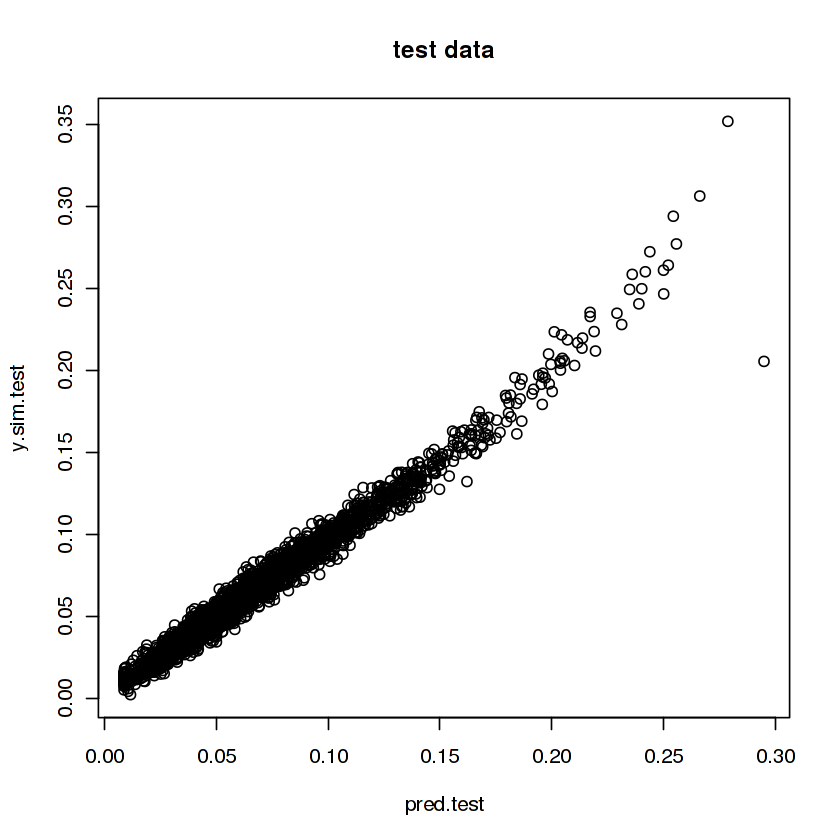

In [21]:
plot(pred.test, y.sim.test, main= "test data")

## Compute the correlation between the actual response and the predicted

In [22]:
cor.train <- cor(pred.train, y.sim.train)
cor.test <- cor(pred.test, y.sim.test)

print("correlation on train:")
print(cor.train)
print("correlation on test:")
print(cor.test)

[1] "correlation on train:"
         [,1]
[1,] 0.978847
[1] "correlation on test:"
          [,1]
[1,] 0.9872949


## Get model weights

In [23]:
model_weights <- get_weights(model)
print(length(model_weights))

[1] 4


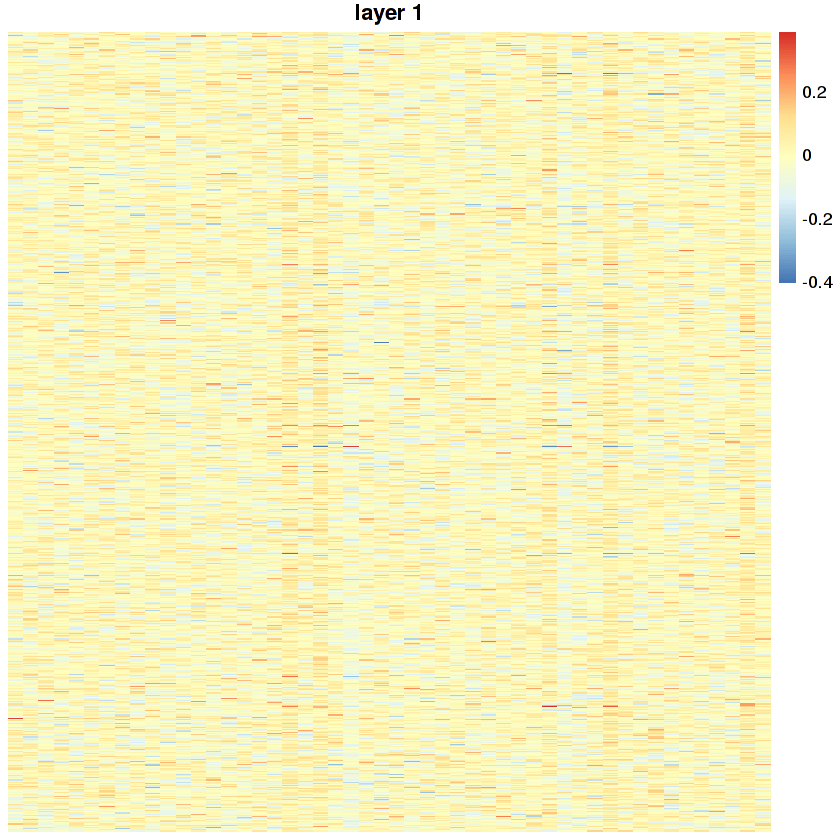

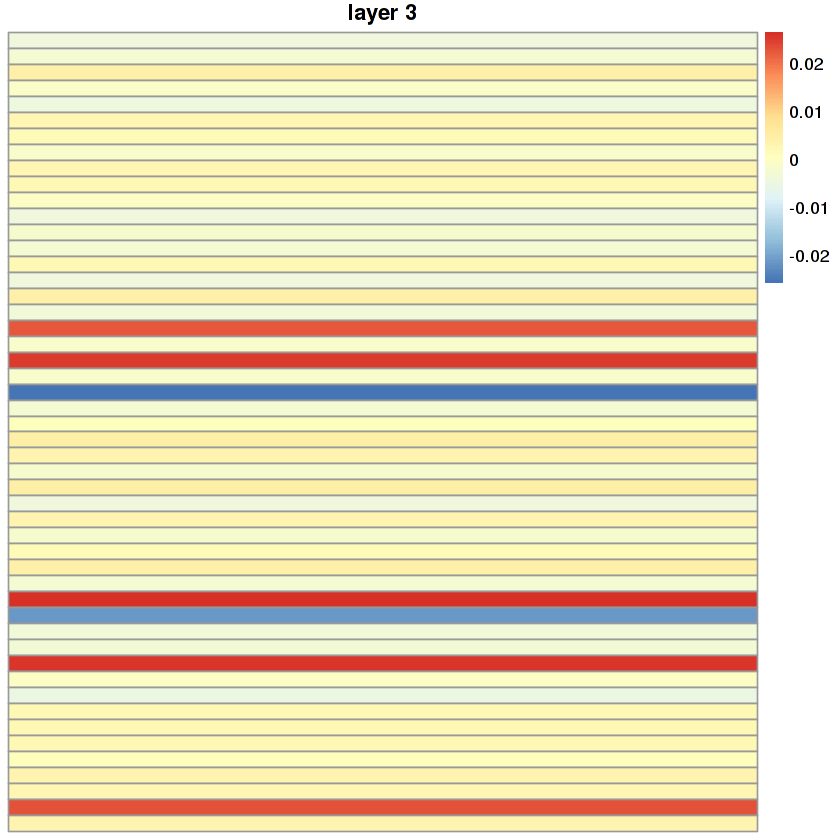

In [24]:
for(i in seq(1, length(model_weights), by= 2)) # Skipping the bias weights
    pheatmap(model_weights[[i]], cluster_rows= F, cluster_cols= F, main= paste("layer", i))

# Conclusion

* Here I defined the response variable as the squared average value taken over all the features per gene
* The same setup used in the [notebook dedicated to the real data](https://github.com/fba67/scMTL/blob/master/bulk_NN.ipynb) is also used here
* The purpose of this study was to check if there is something fundamentally wrong with netwrok topology and other parameters
* The excellent performance of the model on test data indicates that the designed model is well-capable of predicting a non-linear realationship between the features and response variables